# ETF Dip-Buy Signal Advisor - Historical Backtest

This notebook runs the ETF advisor algorithm on 5 years of historical data.

The algorithm uses a **Buy Score (0-100)** system with tiered actions:
- **SMA 200**: Long-term trend filter
- **Drawdown**: 6-month drawdown from high
- **Z-Score**: 30-day z-score

**Tiers**:
- **STRONG_BUY** (≥75): 2.5x baseline DCA
- **BUY** (55-74): 1.5x baseline DCA
- **DCA_ONLY** (35-54): Baseline DCA
- **WAIT** (<35): No buy


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Dict, Optional, Any

In [5]:
TICKERS = [
    "VOO",   # S&P 500 — large-cap U.S. equities (core benchmark)
    "VTI",   # Total U.S. market — large + mid + small cap
    "MGK",   # Mega-cap growth — concentrated big tech/growth tilt
    "QQQ",   # Nasdaq-100 — tech and growth-heavy large caps
    "VTV",   # U.S. value stocks — lower valuation, dividend tilt
    "VB",    # U.S. small-cap stocks — higher volatility, growth optionality
    "VXUS",  # Total international equities — ex-U.S. diversification
    "VEA",   # Developed international markets — Europe/Japan focus
]

# TICKERS = [
#     "MSFT",  # Microsoft — cloud, enterprise software
#     "AAPL",  # Apple — consumer tech ecosystem
#     "AMZN",  # Amazon — e-commerce + AWS cloud
#     "GOOGL", # Alphabet — search, ads, AI
#     "META",  # Meta — social platforms, ads
#     "NVDA",  # Nvidia — AI, GPUs, data centers
#     "TSLA",  # Tesla — EVs, high-volatility growth
# ]

# Algorithm parameters
ZSCORE_WINDOW = 30
LOOKBACK_HIGH_DAYS = 126
SMA_DAYS = 200

# Buy Score parameters
DRAWDOWN_MAX = 0.12
ZSCORE_MAX = 2.5

TIER_STRONG_BUY = 75
TIER_BUY = 55
TIER_DCA_ONLY = 35

class MockConfig:
    def __init__(self):
        self.zscore_window = ZSCORE_WINDOW
        self.lookback_high_days = LOOKBACK_HIGH_DAYS
        self.sma_days = SMA_DAYS
        self.drawdown_max = DRAWDOWN_MAX
        self.zscore_max = ZSCORE_MAX
        self.tier_strong_buy = TIER_STRONG_BUY
        self.tier_buy = TIER_BUY
        self.tier_dca_only = TIER_DCA_ONLY

config = MockConfig()

### Indicator Calculator
Calculates basic technical indicators from daily closing prices.
- SMA 200 (200-day moving average): The average price over the last ~200 trading days. Used to tell whether the ETF is generally trending up or down.
- Drawdown (6-month): How far the current price is below its highest price in the last ~6 months. Used to detect “buy the dip” situations.
- Z-score: Measures how unusually high or low today’s price is compared to recent prices. A negative z-score means the price is lower than normal.





In [6]:
class IndicatorCalculator:    
    def __init__(self, config):
        self.config = config
    
    def calculate_all(self, price_data: pd.DataFrame) -> Dict[str, float]:
        if price_data is None or len(price_data) == 0:
            raise ValueError("Price data is empty")
        
        close_today = float(price_data["Close"].iloc[-1])
        sma_200 = self._calculate_sma(price_data, self.config.sma_days)
        drawdown_6m = self._calculate_drawdown(price_data, self.config.lookback_high_days)
        zscore = self._calculate_zscore(price_data, self.config.zscore_window)
        
        return {
            "close_today": close_today,
            "sma_200": sma_200,
            "drawdown_6m": drawdown_6m,
            "zscore": zscore
        }
    
    def _calculate_sma(self, price_data: pd.DataFrame, window: int) -> Optional[float]:
        if len(price_data) < window:
            return None
        
        closes = price_data["Close"].values
        sma = np.mean(closes[-window:])
        return float(sma)
    
    def _calculate_drawdown(self, price_data: pd.DataFrame, lookback_days: int) -> float:
        if len(price_data) < lookback_days:
            lookback_days = len(price_data)
        
        closes = price_data["Close"].values
        close_today = closes[-1]
        max_close = np.max(closes[-lookback_days:])
        
        drawdown = (close_today / max_close) - 1.0
        return float(drawdown)
    
    def _calculate_zscore(self, price_data: pd.DataFrame, window: int) -> float:
        if len(price_data) < window:
            window = len(price_data)
        
        closes = price_data["Close"].values
        close_today = closes[-1]
        
        rolling_mean = np.mean(closes[-window:])
        rolling_std = np.std(closes[-window:])
        
        if rolling_std == 0:
            return 0.0
        
        zscore = (close_today - rolling_mean) / rolling_std
        return float(zscore)


## Load Historical Data

Load data from CSV files or download from Yahoo Finance if CSV doesn't exist.

In [7]:
def load_ticker_data(ticker: str, years: int = 5) -> pd.DataFrame:
    """
    Load ticker data from CSV if exists, otherwise download from Yahoo Finance.
    
    Args:
        ticker: Ticker symbol
        years: Number of years of data to fetch (if downloading)
        
    Returns:
        DataFrame with Date and Close columns
    """
    csv_path = Path(f"data/{ticker}_5y.csv")
    
    if csv_path.exists():
        print(f"Loading {ticker} from CSV: {csv_path}")
        df = pd.read_csv(csv_path)
        
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'], utc=True)
        elif 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], utc=True)
            df = df.rename(columns={'date': 'Date'})
        if 'Close' not in df.columns and 'close' in df.columns:
            df = df.rename(columns={'close': 'Close'})
        
        df = df.sort_values('Date')
        df = df[df['Close'].notna()]
        
        return df
    else:
        print(f"CSV not found for {ticker}. Downloading from Yahoo Finance...")
        end_date = datetime.now()
        start_date = end_date - timedelta(days=years * 365)
        
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date, interval="1d")
        
        if df.empty:
            print(f"Warning: No data returned for {ticker}")
            return None
        
        # Reset index to make Date a column
        df = df.reset_index()
        df = df.sort_values("Date")
        
        # Filter to only trading days with valid close prices
        df = df[df["Close"].notna()]
        
        # Create data directory if it doesn't exist
        csv_path.parent.mkdir(exist_ok=True)
        
        # Save to CSV for future use
        df.to_csv(csv_path, index=False)
        print(f"Saved {ticker} data to {csv_path} ({len(df)} rows)")
        
        return df

# Load data for all tickers
ticker_data = {}
for ticker in TICKERS:
    try:
        data = load_ticker_data(ticker, years=5)
        if data is not None:
            ticker_data[ticker] = data
            print(f"{ticker}: {len(data)} rows, Date range: {data['Date'].min()} to {data['Date'].max()}\n")
        else:
            print(f"{ticker}: Failed to download data\n")
    except Exception as e:
        print(f"{ticker}: Failed to load data - {str(e)}\n")

Loading VOO from CSV: data/VOO_5y.csv
VOO: 1256 rows, Date range: 2021-01-04 05:00:00+00:00 to 2026-01-02 05:00:00+00:00

Loading VTI from CSV: data/VTI_5y.csv
VTI: 1256 rows, Date range: 2021-01-04 05:00:00+00:00 to 2026-01-02 05:00:00+00:00

Loading MGK from CSV: data/MGK_5y.csv
MGK: 1256 rows, Date range: 2021-01-04 05:00:00+00:00 to 2026-01-02 05:00:00+00:00

Loading QQQ from CSV: data/QQQ_5y.csv
QQQ: 1256 rows, Date range: 2021-01-04 05:00:00+00:00 to 2026-01-02 05:00:00+00:00

Loading VTV from CSV: data/VTV_5y.csv
VTV: 1256 rows, Date range: 2021-01-04 05:00:00+00:00 to 2026-01-02 05:00:00+00:00

Loading VB from CSV: data/VB_5y.csv
VB: 1256 rows, Date range: 2021-01-04 05:00:00+00:00 to 2026-01-02 05:00:00+00:00

Loading VXUS from CSV: data/VXUS_5y.csv
VXUS: 1256 rows, Date range: 2021-01-04 05:00:00+00:00 to 2026-01-02 05:00:00+00:00

Loading VEA from CSV: data/VEA_5y.csv
VEA: 1256 rows, Date range: 2021-01-04 05:00:00+00:00 to 2026-01-02 05:00:00+00:00



## Buy Score Calculation Function

Calculate Buy Score (0-100) and tier from indicators.


In [8]:
def calculate_buy_score(indicators: dict) -> dict:
    close_today = indicators['close_today']
    sma_200 = indicators['sma_200']
    drawdown_6m = indicators['drawdown_6m']
    zscore = indicators['zscore']
    
    # Component 1: Trend score (0-1)
    if sma_200 is None:
        trend_score = 0.0
    else:
        trend_score = 1.0 if close_today > sma_200 else 0.3
    
    # Component 2: Drawdown score (0-1)
    # Map drawdown from 0% to -12% into 0 to 1
    dd = abs(min(drawdown_6m, 0))  # Get absolute value of negative drawdown
    drawdown_score = np.clip(dd / DRAWDOWN_MAX, 0, 1)
    
    # Component 3: Z-score score (0-1)
    # Map zscore from 0 to -2.5 into 0 to 1
    z = abs(min(zscore, 0))  # Get absolute value of negative z-score
    zscore_score = np.clip(z / ZSCORE_MAX, 0, 1)
    
    # Combine with weights: 25% trend, 45% drawdown, 30% z-score
    base_score = 100 * (0.25 * trend_score + 0.45 * drawdown_score + 0.30 * zscore_score)
    buy_score = int(np.clip(base_score, 0, 100))
    
    # Determine tier
    if buy_score >= TIER_STRONG_BUY:
        tier = "STRONG_BUY"
    elif buy_score >= TIER_BUY:
        tier = "BUY"
    elif buy_score >= TIER_DCA_ONLY:
        tier = "DCA_ONLY"
    else:
        tier = "WAIT"
    
    return {
        'buy_score': buy_score,
        'tier': tier,
        'trend_score': trend_score,
        'drawdown_score': drawdown_score,
        'zscore_score': zscore_score,
    }


## Run Algorithm on Historical Data

For each trading day (starting from day 220 to have enough history), calculate indicators and Buy Score.


In [9]:
indicator_calc = IndicatorCalculator(config)
MIN_DAYS_NEEDED = 220
all_results = {}

for ticker, df in ticker_data.items():
    print(f"\n{'='*60}")
    print(f"Processing {ticker}")
    print(f"{'='*60}")
    
    if len(df) < MIN_DAYS_NEEDED:
        print(f"Insufficient data: {len(df)} rows (need {MIN_DAYS_NEEDED})")
        continue
    
    results = []
    
    # Process each day starting from day 220 to length of database
    for i in range(MIN_DAYS_NEEDED, len(df)):
        # Get data up to current day
        current_data = df.iloc[:i+1].copy()
        current_date = current_data.iloc[-1]['Date']
        
        try:
            # Calculate indicators
            indicators = indicator_calc.calculate_all(current_data)
            
            # Calculate Buy Score
            score_result = calculate_buy_score(indicators)
            
            result = {
                'date': current_date,
                'ticker': ticker,
                'close': indicators['close_today'],
                'sma_200': indicators['sma_200'],
                'drawdown_6m': indicators['drawdown_6m'],
                'zscore': indicators['zscore'],
                'buy_score': score_result['buy_score'],
                'tier': score_result['tier'],
                'trend_score': score_result['trend_score'],
                'drawdown_score': score_result['drawdown_score'],
                'zscore_score': score_result['zscore_score'],
            }
            results.append(result)
            
        except Exception as e:
            print(f"Error processing {current_date}: {str(e)}")
            continue
    
    all_results[ticker] = pd.DataFrame(results)
    print(f"Processed {len(results)} days for {ticker}")
    
    # Count by tier
    tier_counts = pd.DataFrame(results)['tier'].value_counts()
    print(f"\nTier distribution:")
    for tier in ['STRONG_BUY', 'BUY', 'DCA_ONLY', 'WAIT']:
        count = tier_counts.get(tier, 0)
        pct = count / len(results) * 100
        print(f"  {tier:12s}: {count:4d} ({pct:5.2f}%)")

print("\n" + "="*60)
print("Processing complete!")



Processing VOO
Processed 1036 days for VOO

Tier distribution:
  STRONG_BUY  :   34 ( 3.28%)
  BUY         :  178 (17.18%)
  DCA_ONLY    :  276 (26.64%)
  WAIT        :  548 (52.90%)

Processing VTI
Processed 1036 days for VTI

Tier distribution:
  STRONG_BUY  :   37 ( 3.57%)
  BUY         :  185 (17.86%)
  DCA_ONLY    :  291 (28.09%)
  WAIT        :  523 (50.48%)

Processing MGK
Processed 1036 days for MGK

Tier distribution:
  STRONG_BUY  :   54 ( 5.21%)
  BUY         :  234 (22.59%)
  DCA_ONLY    :  269 (25.97%)
  WAIT        :  479 (46.24%)

Processing QQQ
Processed 1036 days for QQQ

Tier distribution:
  STRONG_BUY  :   61 ( 5.89%)
  BUY         :  228 (22.01%)
  DCA_ONLY    :  290 (27.99%)
  WAIT        :  457 (44.11%)

Processing VTV
Processed 1036 days for VTV

Tier distribution:
  STRONG_BUY  :   19 ( 1.83%)
  BUY         :  157 (15.15%)
  DCA_ONLY    :  295 (28.47%)
  WAIT        :  565 (54.54%)

Processing VB
Processed 1036 days for VB

Tier distribution:
  STRONG_BUY  :   

## Results Summary

Summary statistics for each ticker with Buy Score analysis.


In [10]:
for ticker, results_df in all_results.items():
    print(f"\n{'='*80}")
    print(f"{ticker} - Summary Statistics")
    print(f"{'='*80}")
    
    total_days = len(results_df)
    
    print(f"\nTotal trading days analyzed: {total_days}")
    print(f"Average Buy Score: {results_df['buy_score'].mean():.1f}")
    print(f"Min Buy Score: {results_df['buy_score'].min()}")
    print(f"Max Buy Score: {results_df['buy_score'].max()}")
    
    # Tier distribution
    print(f"\nTier Distribution:")
    for tier in ['STRONG_BUY', 'BUY', 'DCA_ONLY', 'WAIT']:
        tier_df = results_df[results_df['tier'] == tier]
        count = len(tier_df)
        pct = count / total_days * 100
        avg_score = tier_df['buy_score'].mean() if count > 0 else 0
        print(f"  {tier:12s}: {count:4d} ({pct:5.2f}%) | Avg Score: {avg_score:5.1f}")
    
    # Calculate forward returns by tier (21 trading days ≈ 1 month)
    print(f"\nForward 21-Day Returns by Tier:")
    results_df_sorted = results_df.sort_values('date').copy()
    
    # Add forward return column
    results_df_sorted['forward_21d_return'] = np.nan
    for i in range(len(results_df_sorted) - 21):
        current_close = results_df_sorted.iloc[i]['close']
        future_close = results_df_sorted.iloc[i + 21]['close']
        forward_return = (future_close / current_close) - 1
        results_df_sorted.iloc[i, results_df_sorted.columns.get_loc('forward_21d_return')] = forward_return
    
    for tier in ['STRONG_BUY', 'BUY', 'DCA_ONLY', 'WAIT']:
        tier_df = results_df_sorted[results_df_sorted['tier'] == tier]
        valid_returns = tier_df['forward_21d_return'].dropna()
        if len(valid_returns) > 0:
            avg_return = valid_returns.mean()
            print(f"  {tier:12s}: {avg_return:6.2%} (n={len(valid_returns)})")
        else:
            print(f"  {tier:12s}: N/A (insufficient data)")
    
    print(f"\nPrice Statistics:")
    print(f"  Starting price: ${results_df.iloc[0]['close']:.2f}")
    print(f"  Ending price: ${results_df.iloc[-1]['close']:.2f}")
    print(f"  Price change: {(results_df.iloc[-1]['close'] / results_df.iloc[0]['close'] - 1):.2%}")
    print(f"  Min price: ${results_df['close'].min():.2f}")
    print(f"  Max price: ${results_df['close'].max():.2f}")



VOO - Summary Statistics

Total trading days analyzed: 1036
Average Buy Score: 39.8
Min Buy Score: 25
Max Buy Score: 86

Tier Distribution:
  STRONG_BUY  :   34 ( 3.28%) | Avg Score:  79.0
  BUY         :  178 (17.18%) | Avg Score:  64.3
  DCA_ONLY    :  276 (26.64%) | Avg Score:  44.1
  WAIT        :  548 (52.90%) | Avg Score:  27.2

Forward 21-Day Returns by Tier:
  STRONG_BUY  :  2.74% (n=34)
  BUY         :  2.04% (n=178)
  DCA_ONLY    :  0.28% (n=275)
  WAIT        :  0.97% (n=528)

Price Statistics:
  Starting price: $405.67
  Ending price: $628.30
  Price change: 54.88%
  Min price: $312.90
  Max price: $634.84

VTI - Summary Statistics

Total trading days analyzed: 1036
Average Buy Score: 40.6
Min Buy Score: 25
Max Buy Score: 87

Tier Distribution:
  STRONG_BUY  :   37 ( 3.57%) | Avg Score:  78.9
  BUY         :  185 (17.86%) | Avg Score:  64.4
  DCA_ONLY    :  291 (28.09%) | Avg Score:  43.9
  WAIT        :  523 (50.48%) | Avg Score:  27.6

Forward 21-Day Returns by Tier:
  S

## Visualize Results

Plot price history with Buy Score tiers marked.


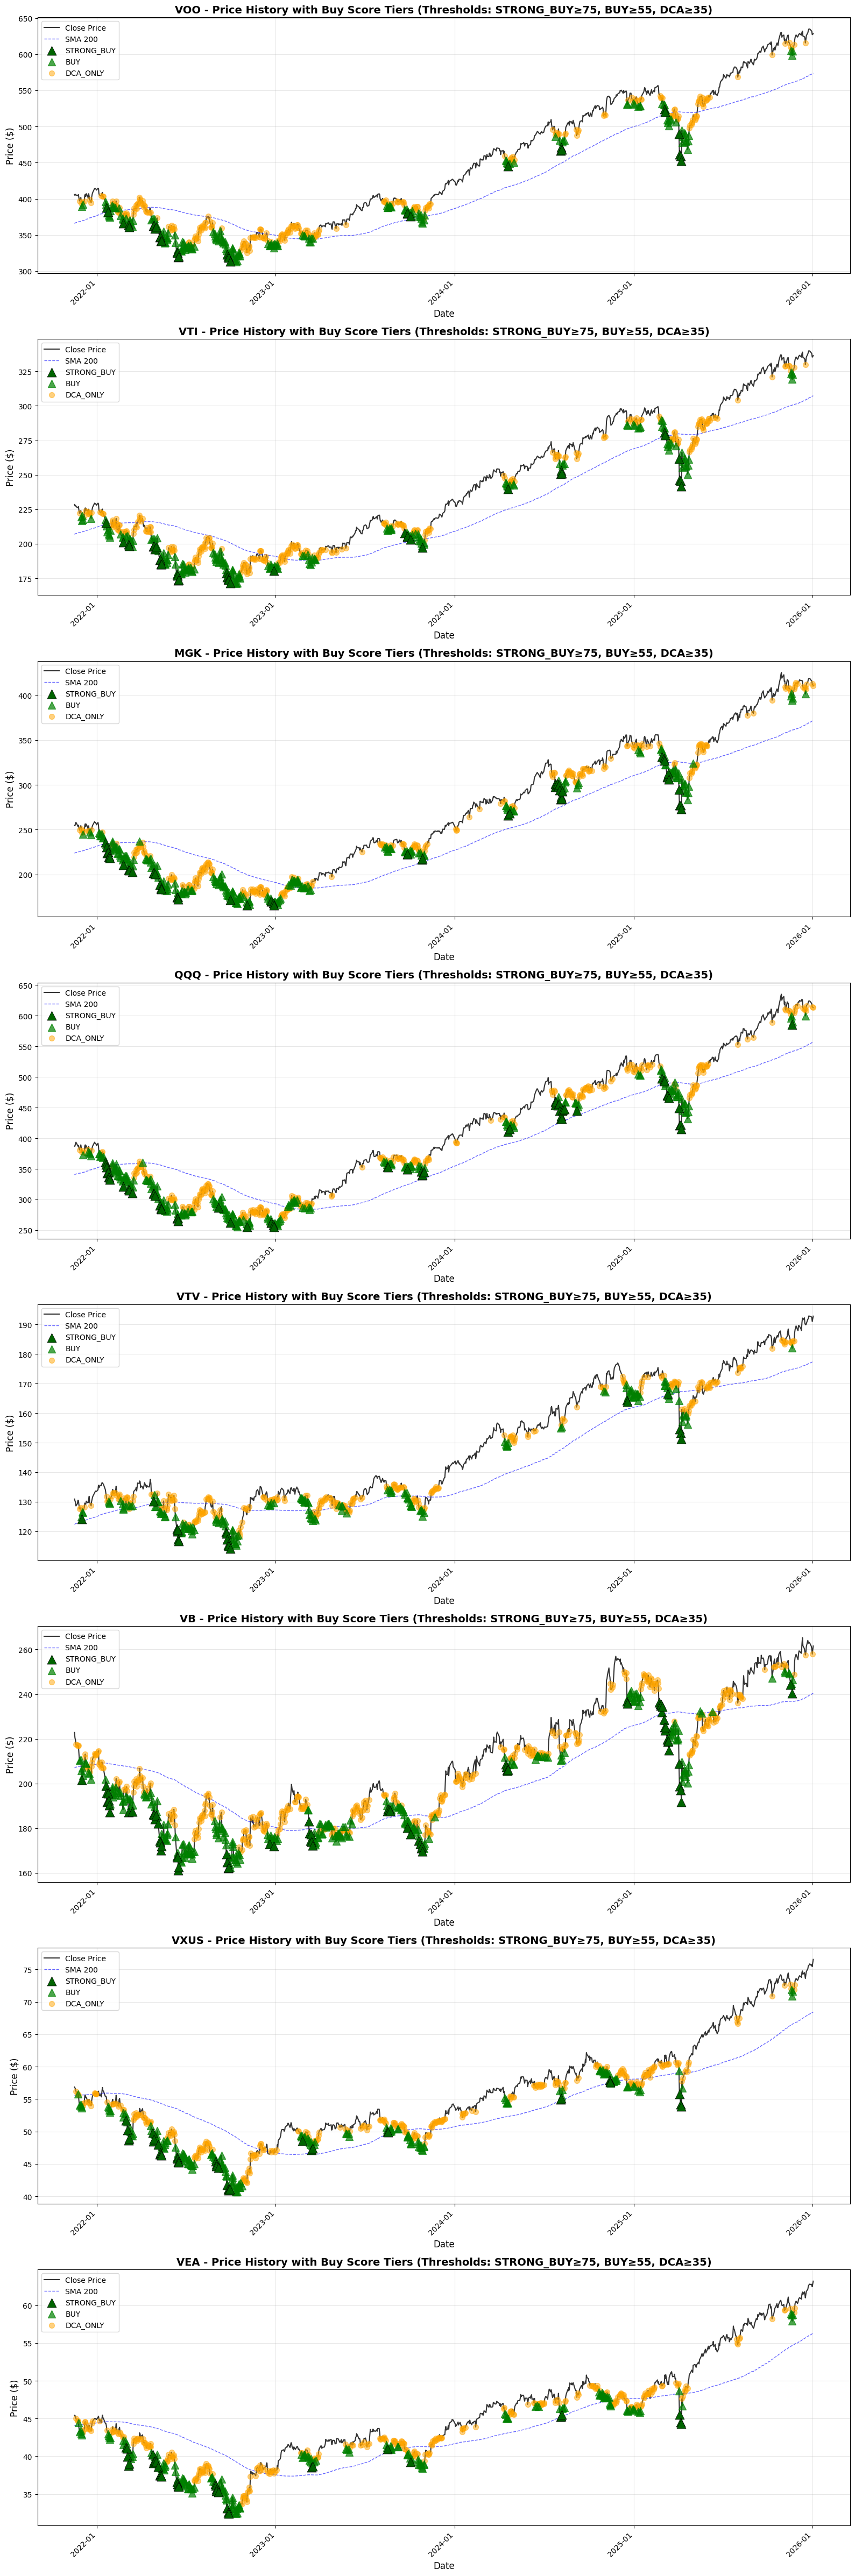

In [11]:
fig, axes = plt.subplots(len(all_results), 1, figsize=(16, 6*len(all_results)))
if len(all_results) == 1:
    axes = [axes]

for idx, (ticker, results_df) in enumerate(all_results.items()):
    ax = axes[idx]
    
    # Plot price
    ax.plot(results_df['date'], results_df['close'], label='Close Price', linewidth=1.5, color='black', alpha=0.8)
    
    # Plot SMA 200
    ax.plot(results_df['date'], results_df['sma_200'], label='SMA 200', linewidth=1, color='blue', alpha=0.6, linestyle='--')
    
    # Mark tiers with different markers
    strong_buy_df = results_df[results_df['tier'] == 'STRONG_BUY']
    buy_df = results_df[results_df['tier'] == 'BUY']
    dca_df = results_df[results_df['tier'] == 'DCA_ONLY']
    
    if len(strong_buy_df) > 0:
        ax.scatter(strong_buy_df['date'], strong_buy_df['close'], 
                  color='darkgreen', marker='^', s=150, label='STRONG_BUY', zorder=5, edgecolors='black', linewidths=0.5)
    if len(buy_df) > 0:
        ax.scatter(buy_df['date'], buy_df['close'], 
                  color='green', marker='^', s=100, label='BUY', zorder=4, alpha=0.7)
    if len(dca_df) > 0:
        ax.scatter(dca_df['date'], dca_df['close'], 
                  color='orange', marker='o', s=50, label='DCA_ONLY', zorder=3, alpha=0.5)
    
    ax.set_title(f'{ticker} - Price History with Buy Score Tiers (Thresholds: STRONG_BUY≥{TIER_STRONG_BUY}, BUY≥{TIER_BUY}, DCA≥{TIER_DCA_ONLY})', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


## Buy Score Over Time

Plot Buy Score over time to see signal frequency.


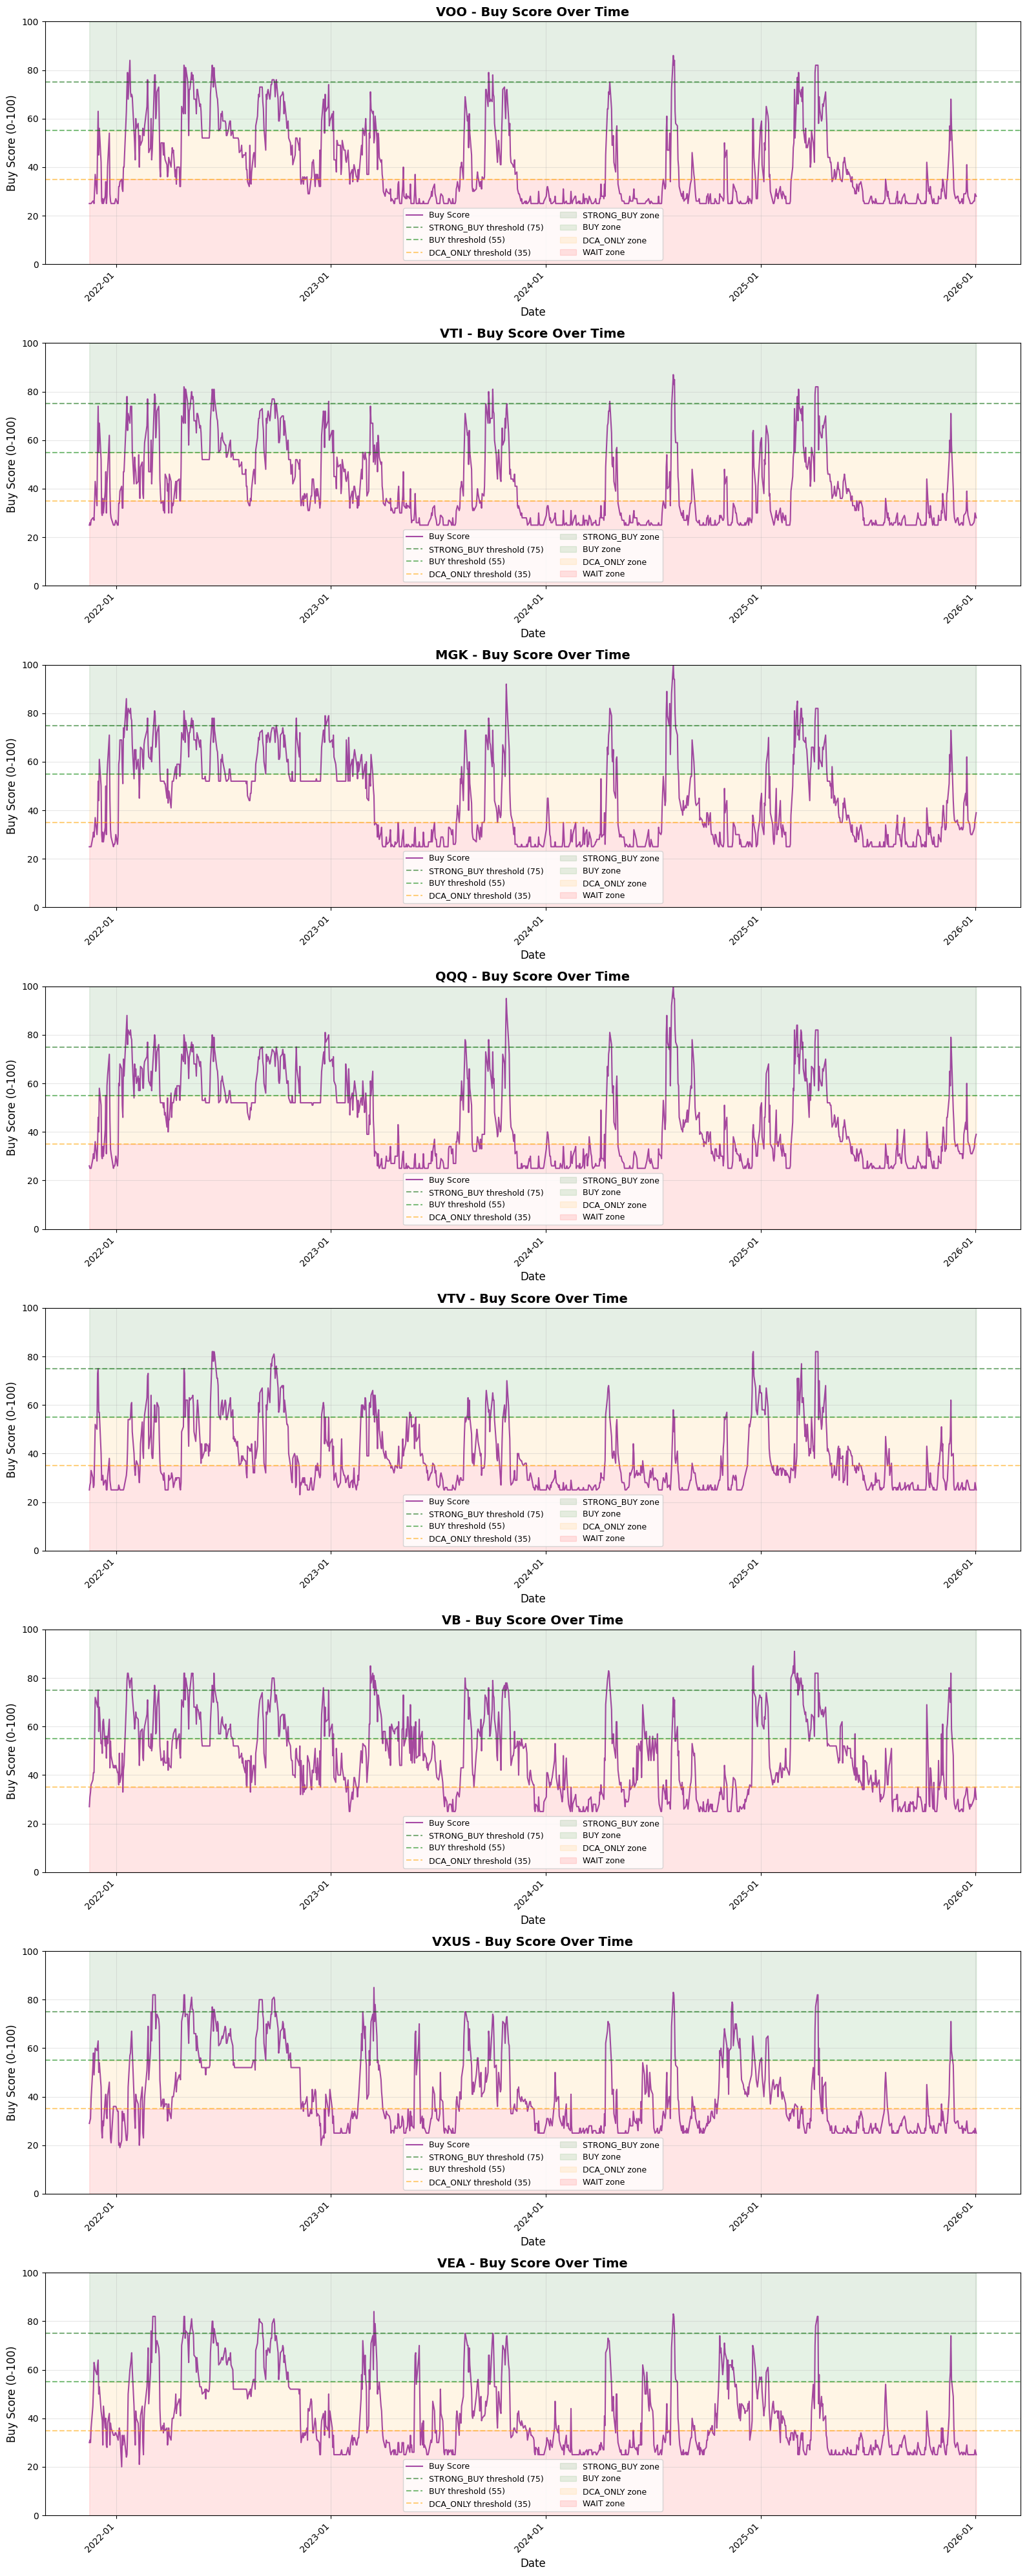

In [12]:
fig, axes = plt.subplots(len(all_results), 1, figsize=(16, 5*len(all_results)))
if len(all_results) == 1:
    axes = [axes]

for idx, (ticker, results_df) in enumerate(all_results.items()):
    ax = axes[idx]
    
    # Plot Buy Score
    ax.plot(results_df['date'], results_df['buy_score'], label='Buy Score', linewidth=1.5, color='purple', alpha=0.7)
    
    # Add tier threshold lines
    ax.axhline(y=TIER_STRONG_BUY, color='darkgreen', linestyle='--', alpha=0.5, label=f'STRONG_BUY threshold ({TIER_STRONG_BUY})')
    ax.axhline(y=TIER_BUY, color='green', linestyle='--', alpha=0.5, label=f'BUY threshold ({TIER_BUY})')
    ax.axhline(y=TIER_DCA_ONLY, color='orange', linestyle='--', alpha=0.5, label=f'DCA_ONLY threshold ({TIER_DCA_ONLY})')
    
    # Fill areas for different tiers
    ax.fill_between(results_df['date'], TIER_STRONG_BUY, 100, alpha=0.1, color='darkgreen', label='STRONG_BUY zone')
    ax.fill_between(results_df['date'], TIER_BUY, TIER_STRONG_BUY, alpha=0.1, color='green', label='BUY zone')
    ax.fill_between(results_df['date'], TIER_DCA_ONLY, TIER_BUY, alpha=0.1, color='orange', label='DCA_ONLY zone')
    ax.fill_between(results_df['date'], 0, TIER_DCA_ONLY, alpha=0.1, color='red', label='WAIT zone')
    
    ax.set_title(f'{ticker} - Buy Score Over Time', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Buy Score (0-100)', fontsize=12)
    ax.set_ylim(0, 100)
    ax.legend(loc='best', fontsize=9, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


## Detailed Signals by Tier

Show all signals for each tier with their metrics.


In [13]:
for ticker, results_df in all_results.items():
    print(f"\n{'='*100}")
    print(f"{ticker} - Signals by Tier")
    print(f"{'='*100}")
    
    for tier in ['STRONG_BUY', 'BUY', 'DCA_ONLY', 'WAIT']:
        tier_df = results_df[results_df['tier'] == tier].copy()
        
        if len(tier_df) == 0:
            print(f"\n{tier}: No signals")
            continue
        
        print(f"\n{tier} ({len(tier_df)} signals):")
        print("-" * 100)
        
        display_df = tier_df[['date', 'close', 'sma_200', 'drawdown_6m', 'zscore', 'buy_score']].copy()
        
        if not pd.api.types.is_datetime64_any_dtype(display_df['date']):
            display_df['date'] = pd.to_datetime(display_df['date'], utc=True)
        else:
            if display_df['date'].dt.tz is not None:
                display_df['date'] = display_df['date'].dt.tz_convert('UTC').dt.tz_localize(None)
        
        display_df['date'] = display_df['date'].dt.strftime('%Y-%m-%d')
        display_df['close'] = display_df['close'].apply(lambda x: f"${x:.2f}")
        display_df['sma_200'] = display_df['sma_200'].apply(lambda x: f"${x:.2f}" if pd.notna(x) else "N/A")
        display_df['drawdown_6m'] = display_df['drawdown_6m'].apply(lambda x: f"{x:.2%}")
        display_df['zscore'] = display_df['zscore'].apply(lambda x: f"{x:.2f}")
        display_df['buy_score'] = display_df['buy_score'].apply(lambda x: f"{x}")        
        display_df.columns = ['Date', 'Close', 'SMA 200', 'Drawdown', 'Z-Score', 'Buy Score']
        
        # Show first 20 if many signals
        if len(display_df) > 20:
            print(display_df.head(20).to_string(index=False))
            print(f"\n... and {len(display_df) - 20} more signals")
        else:
            print(display_df.to_string(index=False))


VOO - Signals by Tier

STRONG_BUY (34 signals):
----------------------------------------------------------------------------------------------------
      Date   Close SMA 200 Drawdown Z-Score Buy Score
2022-01-20 $387.67 $381.02   -6.49%   -2.64        79
2022-01-24 $381.63 $381.31   -7.94%   -2.44        84
2022-02-23 $366.01 $384.11  -11.71%   -2.11        76
2022-03-07 $363.93 $384.95  -12.21%   -2.14        78
2022-03-08 $361.18 $384.97  -12.87%   -2.18        78
2022-04-26 $362.25 $388.15  -12.62%   -2.67        82
2022-04-27 $363.19 $388.09  -12.39%   -2.42        81
2022-04-29 $358.61 $387.99  -13.49%   -2.44        81
2022-05-02 $360.87 $387.94  -12.95%   -2.00        76
2022-05-09 $346.49 $387.61  -16.42%   -2.25        79
2022-05-10 $347.38 $387.45  -16.20%   -1.98        76
2022-05-11 $341.78 $387.26  -17.55%   -2.13        78
2022-05-12 $341.52 $387.08  -17.62%   -1.96        76
2022-06-13 $326.19 $383.75  -21.32%   -2.53        82
2022-06-14 $325.37 $383.43  -21.51%   -2

In [14]:
# Export results to CSV if necessary...
# output_dir = Path("results")
# output_dir.mkdir(exist_ok=True)

# for ticker, results_df in all_results.items():
#     # Prepare export dataframe
#     export_df = results_df.copy()
    
#     # Handle date column - convert timezone-aware to naive datetime
#     if pd.api.types.is_datetime64_any_dtype(export_df['date']):
#         if export_df['date'].dt.tz is not None:
#             # Convert timezone-aware to UTC then remove timezone
#             export_df['date'] = export_df['date'].dt.tz_convert('UTC').dt.tz_localize(None)
#         # Format as string for CSV
#         export_df['date'] = export_df['date'].dt.strftime('%Y-%m-%d')
#     else:
#         # If not datetime, try to convert
#         export_df['date'] = pd.to_datetime(export_df['date'], utc=True).dt.tz_localize(None).dt.strftime('%Y-%m-%d')
    
#     output_file = output_dir / f"{ticker}_backtest_results.csv"
#     export_df.to_csv(output_file, index=False)
#     print(f"Exported {ticker} results to {output_file}")
#     print(f"  - Total rows: {len(export_df)}")
#     print(f"  - Columns: {', '.join(export_df.columns)}")

# print("\nAll results exported successfully!")